In [1]:
import itertools
import os
import functools
import dataclasses
import packaging.version
from typing import List, Sequence, Set, Iterator, Optional

import libmambapy
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import mamba_error_reporting as mer

pd.set_option("max_colwidth", None)
pd.set_option("display.max_columns", None)

%matplotlib inline

## Previous error message

In [2]:
solver, pool = mer.problems.create_pubgrub_missing()
success = solver.solve()
if not success:
    print(mer.messaging.old_error_report(solver))

Mamba failed to solve. The reported errors are:
   Encountered problems while solving:
     - nothing provides libnothere >1.0 needed by dropdown-2.9.3
   


## Raw libsolv data

In [3]:
pbs = mer.analysis.all_problems_structured_df(solver)
deps = mer.analysis.select_solvables_df(
    pool, pbs[~pbs.dependency.isnull()].dependency_id.drop_duplicates()
)
solvables = mer.analysis.id_to_pkg_info_df(pool,
    itertools.chain(
    pbs[pbs.source_is_pkg].source_id,
    pbs[pbs.target_is_pkg].target_id,
    deps.solvable_id
)).drop_duplicates().set_index('id').sort_index()

## Original graph

In [4]:
def plot_dag(graph: nx.DiGraph, node_labels=None, edge_labels=None) -> None:
    plt.figure(figsize=(10, 6), dpi=300)

    # Position using levels
    pos = {}
    for level, nodes in enumerate(nx.topological_generations(graph)):
        nodes = sorted(nodes, key=lambda n: graph[n].get("name", "None"))
        pos.update({n: (x, -level - 0.2*(x%2)) for x, n in enumerate(nodes)})

    options = {"node_size": 800, "alpha": 0.5}
    nx.draw_networkx_nodes(graph, pos, node_color="blue", **options)
    nx.draw_networkx_edges(graph, pos, **options)

    if node_labels is not None:
        nx.draw_networkx_labels(graph, pos, node_labels, font_size=7)
    if edge_labels is not None:
        nx.draw_networkx_edge_labels(graph, pos, edge_labels, font_size=7)

    plt.tight_layout()
    plt.axis("off")
    plt.show()


def repr_pkg_info(p: libmambapy.PackageInfo) -> str:
    return f"{p.name}-{p.version}-{p.build_number}"

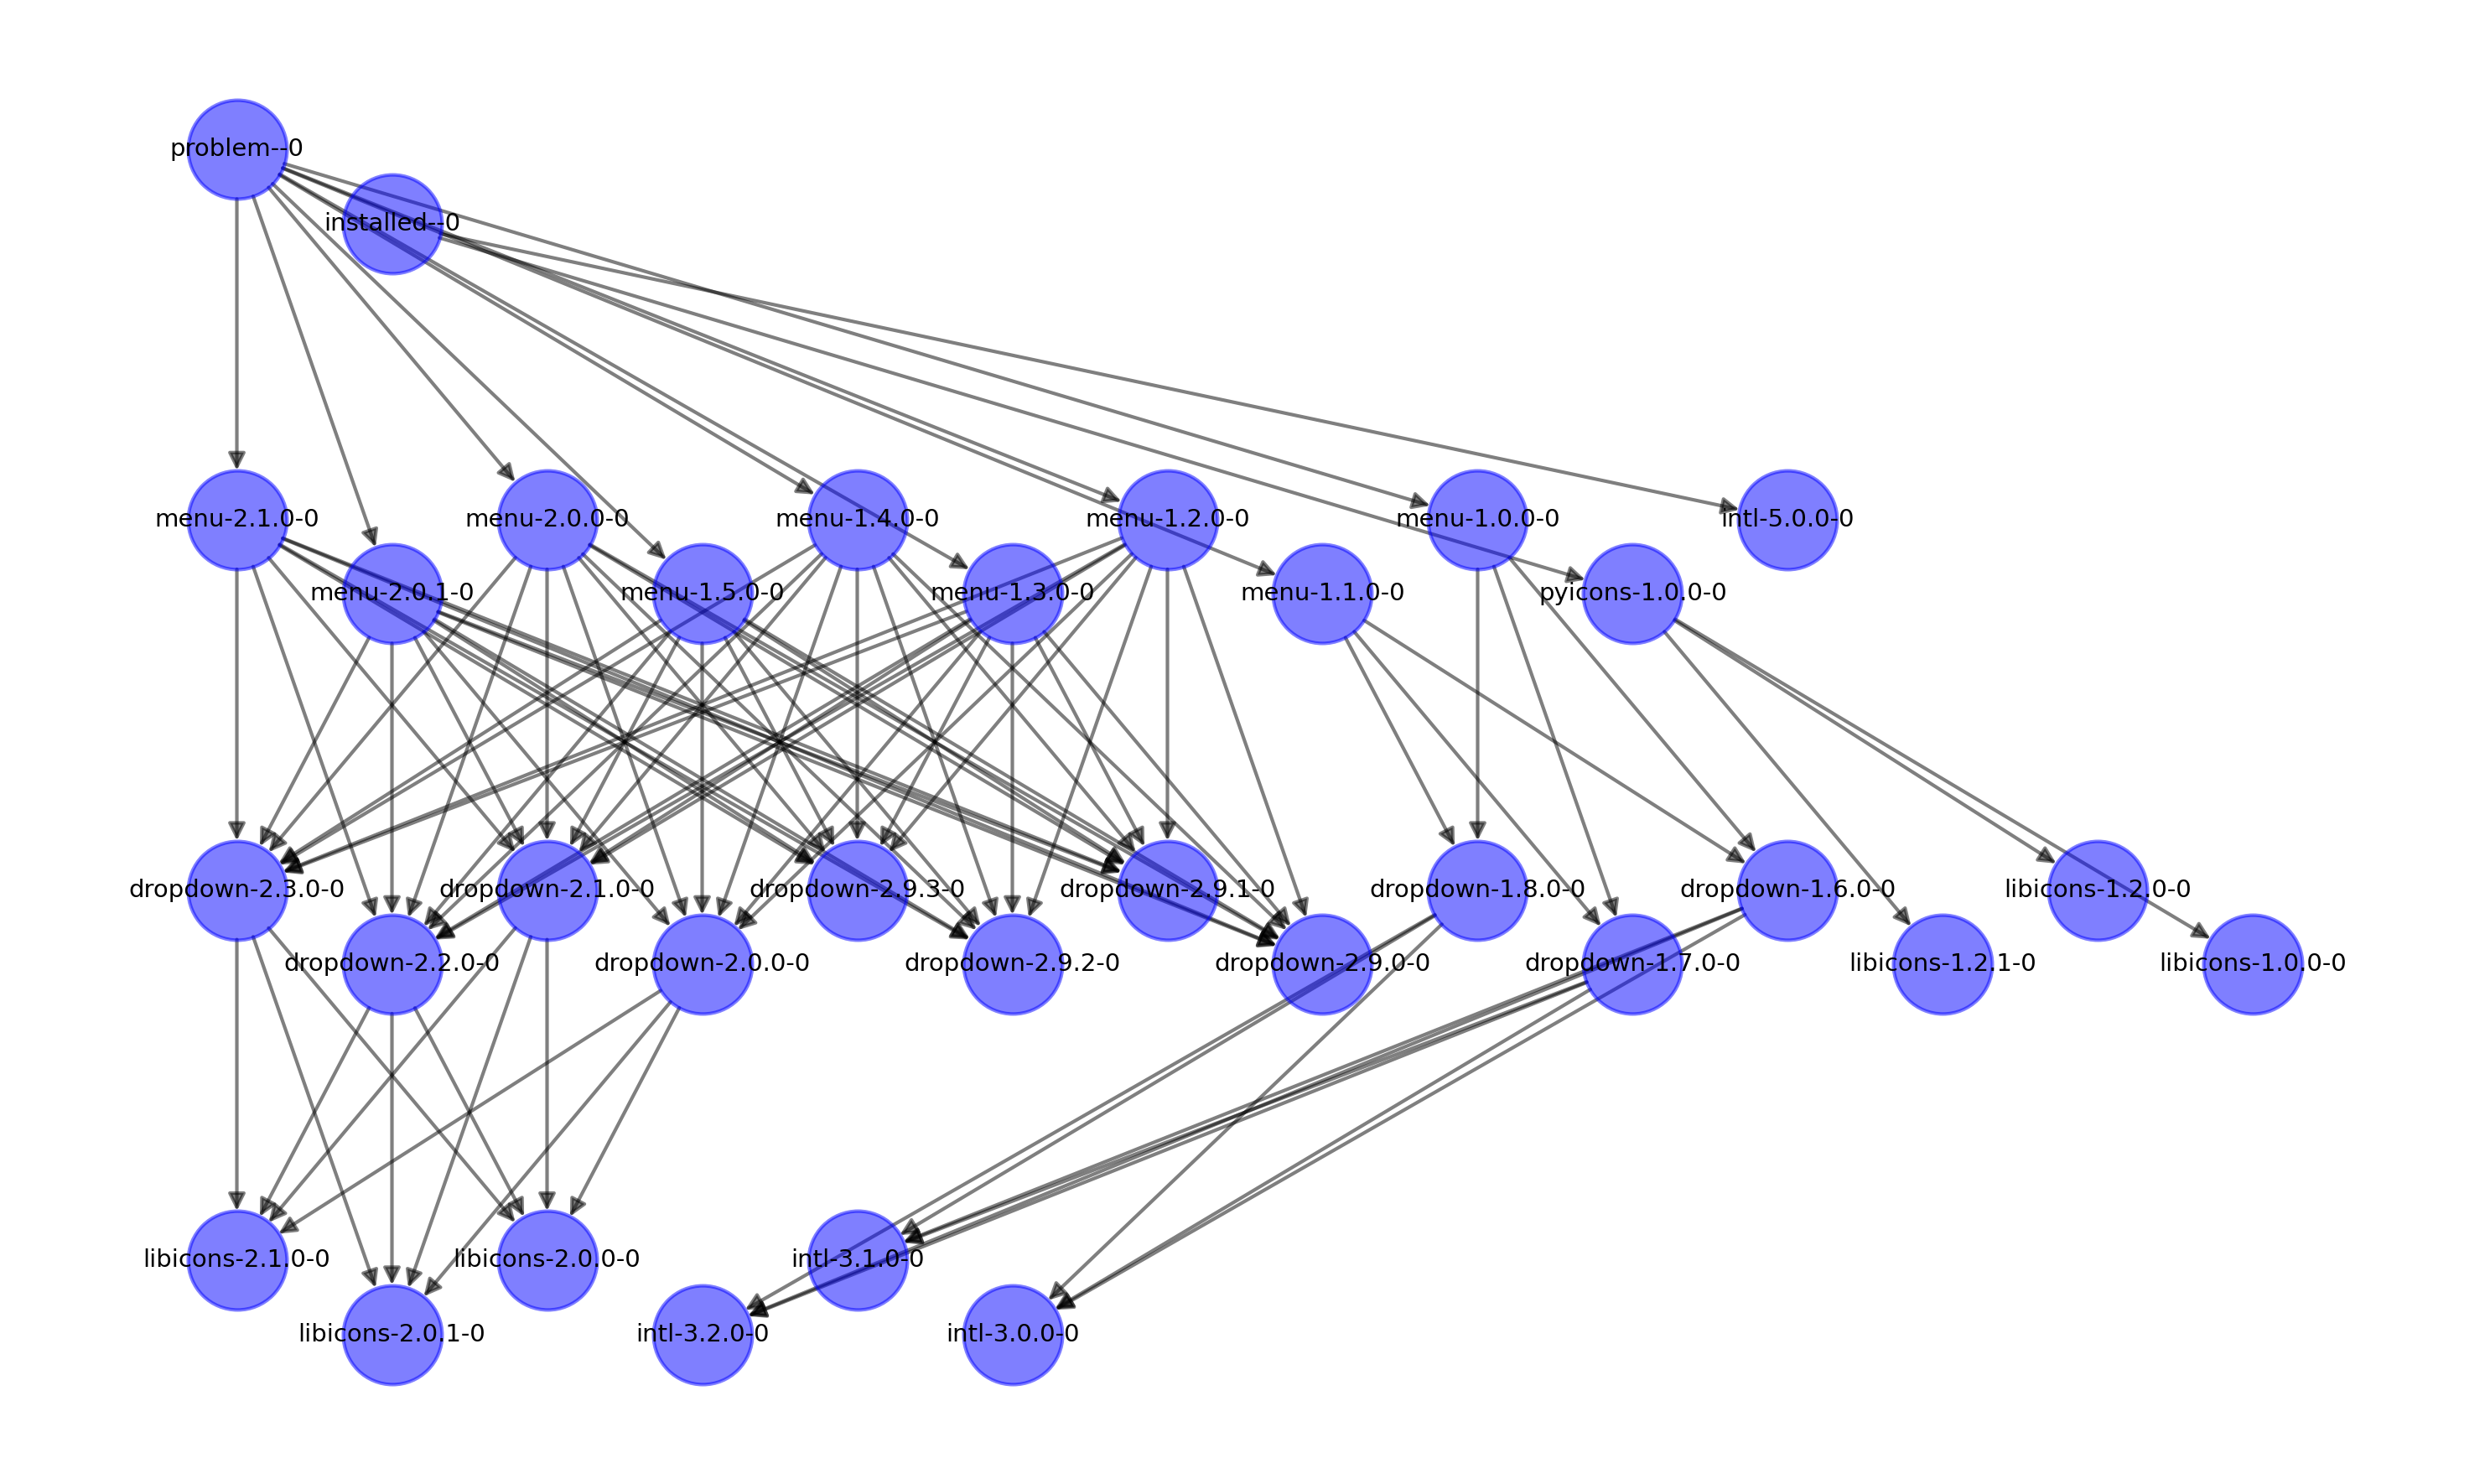

In [5]:
pb_data = mer.algorithm.ProblemData.from_libsolv(solver, pool)
plot_dag(pb_data.graph, node_labels={n: repr_pkg_info(pb_data.package_info[n]) for n in pb_data.graph.nodes})

## Compressed graph

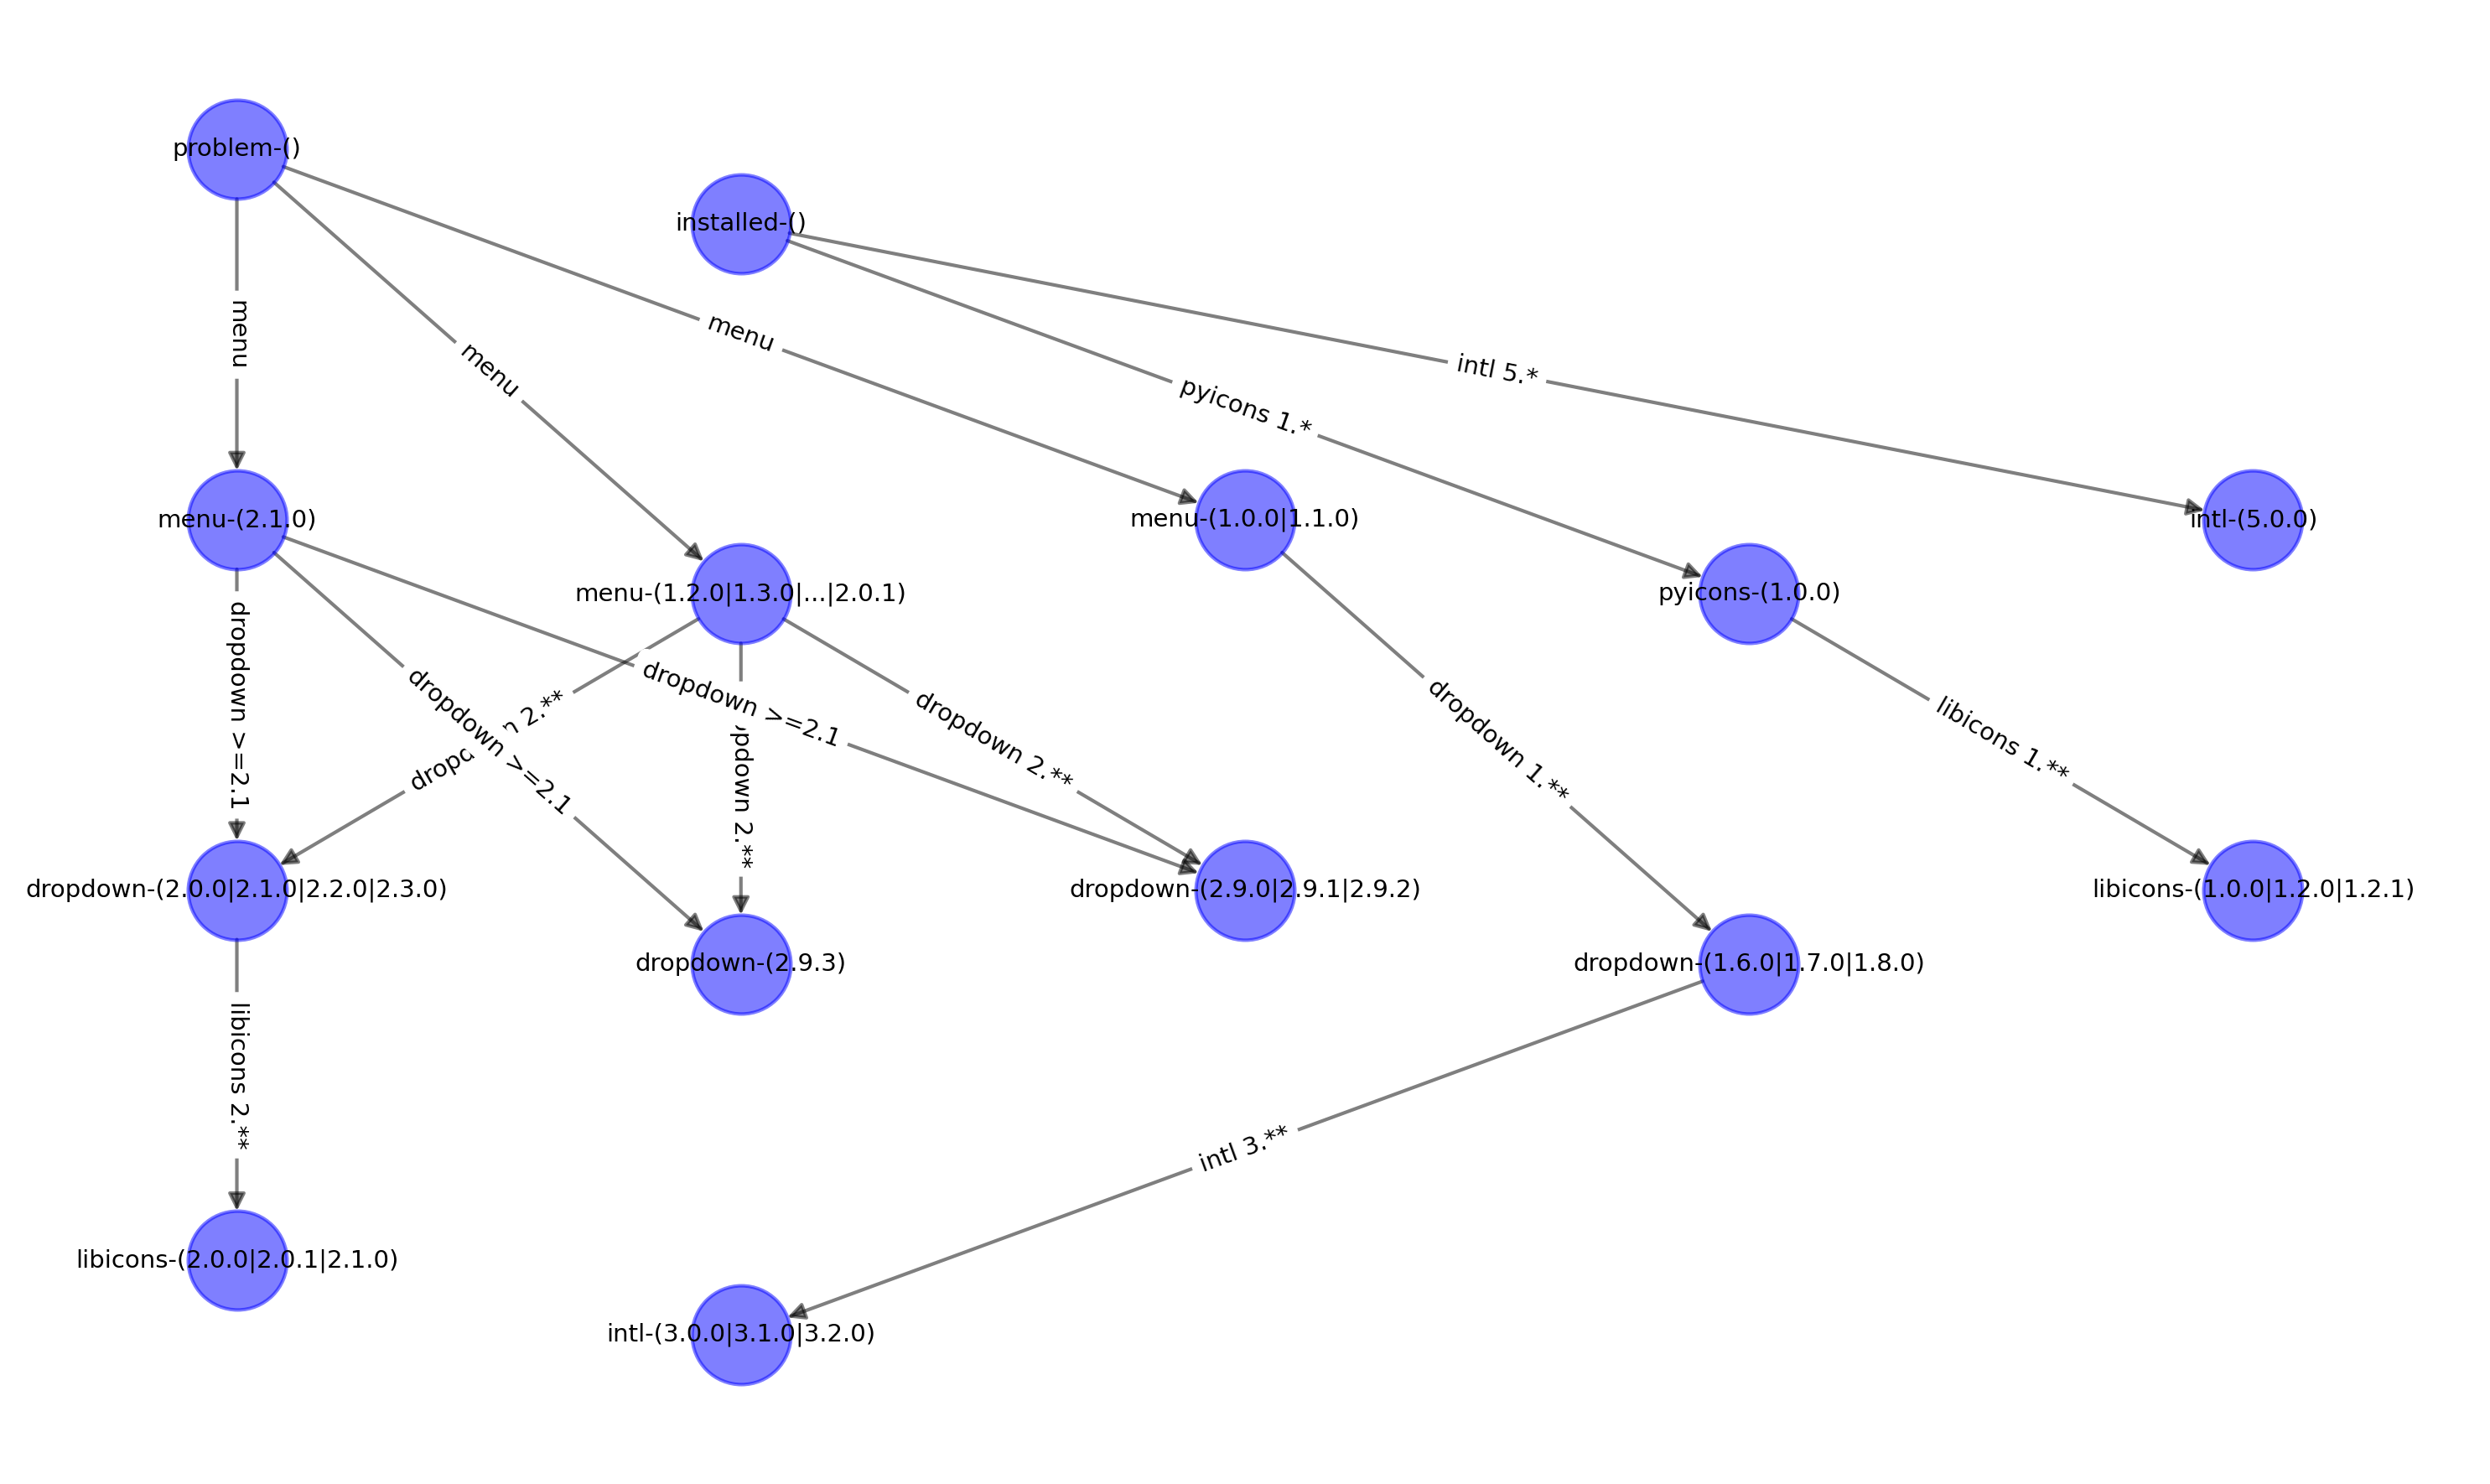

In [6]:
def graph_groups_labels(graph: nx.DiGraph, package_info, groups) -> dict:
    labels = {}
    for n in graph.nodes:
        solvs = [package_info.get(s) for s in groups.group_to_solv[n]]
        name = next(iter(solvs)).name
        versions = {p.version for p in solvs}
        versions = sorted(versions, key=packaging.version.parse)
        # Truncate versions too long
        if len(versions) > 5:
            versions = versions[:2] + ["..."] + versions[-1:]
        labels[n] = f"{name}-(" + "|".join(versions) + ")"
    return labels


cp_data = mer.algorithm.compress_graph(pb_data)
plot_dag(
    cp_data.graph,
    node_labels=graph_groups_labels(cp_data.graph, pb_data.package_info, cp_data.groups),
    edge_labels={e: pb_data.dependency_names[attr["dependency_id"]] for e, attr in cp_data.graph.edges.items()},
)

## Error message

In [7]:
print(mer.algorithm.explain_graph(pb_data, cp_data))

Error: Could not install any versions from requested package menu.

  intl 5.* is requested and could be installed.
  A package satisfying pyicons 1.* is requested, and it requires
    libicons 1.**, which could be installed.

  This implies that menu cannot be installed because none of the following versions can be installed
    menu [1.1.0|1.0.0], which requires
      dropdown 1.**, which requires
        intl 3.**, which conflicts with any possible versions of intl;
    menu [2.0.1|1.3.0|...|1.2.0|1.5.0], which requires
      dropdown 2.** for which none of the following versions can be installed
        dropdown [2.9.2|2.9.1|2.9.0], which requires the missing package libicons >10.0;
        dropdown [2.9.3], which requires the missing package libnothere >1.0;
        dropdown [2.0.0|2.2.0|2.1.0|2.3.0], which requires
          libicons 2.**, which conflicts with any possible versions of libicons;
    menu [2.1.0], which requires
      dropdown >=2.1 for which none of the following 